In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
title = 'SARIMAX STB 6-3-1'
train_ratio = 0.6
test_ratio = 0.3
#Mảng chứa giá trị để kiểm tra chu kỳ từ 2 đến 10 ngày (2 tuần)
seasonal_arr = np.array(range(2, 11))
seasonal_arr

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])

In [3]:
df=pd.read_csv('../../STB Historical Data.csv',index_col='Date',parse_dates=True)
#đảo ngược dữ liệu
df=df.iloc[::-1]

In [4]:
#Thêm tập dữ liệu VN Index
df_vni=pd.read_csv('../../VN Index Historical Data.csv',index_col='Date',parse_dates=True)
df_vni=df_vni.iloc[::-1]

In [5]:
df_vni=df_vni['Price'].replace(',','',regex=True).astype(float)

In [6]:
#Chuyển dữ liệu lần cuối, % thay đổi về dạng int
df=df['Price'].replace(',','',regex=True).astype(float)

In [7]:
#Chia dư liệu thành 2 phần train và test với tỉ lệ 70:30
train_size = int(train_ratio * len(df))
test_size = int(test_ratio * len(df))
val_size = len(df) - train_size - test_size

train = df[:train_size]
test = df[train_size:train_size+test_size]
val = df[train_size+test_size:]

vni_train=df_vni[:train_size]
vni_test=df_vni[train_size:train_size+test_size]
vni_val=df_vni[train_size+test_size:]

In [8]:
#Làm hàm cho vào mảng seasonal_arr và chạy qua với auto arima để tìm ra chu kỳ tốt nhất
#Đối với mỗi lần lặp ta sẽ xét xem model nào có chỉ số AIC tốt nhất để lấy
def grid_search(arr):
    best_aic=0
    for i in arr:
        print("Seasonal Period: ",i)
        model=auto_arima(train,exog=vni_train,seasonal=True,m=i, error_action='ignore', suppress_warnings=True)
        print("AIC: ",model.aic())
        print("------------------")
        if model.aic()<best_aic or best_aic==0:
            best_aic=model.aic()
            best_model=model
    return best_model

In [9]:
search=grid_search(seasonal_arr)
search.summary()

Seasonal Period:  2
AIC:  9948.899148537872
------------------
Seasonal Period:  3
AIC:  9838.298602058394
------------------
Seasonal Period:  4
AIC:  9838.298602058394
------------------
Seasonal Period:  5
AIC:  9838.298602058394
------------------
Seasonal Period:  6
AIC:  9838.298602058394
------------------
Seasonal Period:  7
AIC:  9828.986068495633
------------------
Seasonal Period:  8
AIC:  9838.298602058394
------------------
Seasonal Period:  9
AIC:  9838.298602058394
------------------
Seasonal Period:  10
AIC:  9838.298602058394
------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  660
Model:             SARIMAX(2, 1, 2)x(0, 0, 2, 7)   Log Likelihood               -4906.493
Date:                           Sat, 03 Jun 2023   AIC                           9828.986
Time:                                   21:36:56   BIC                           9864.912
Sample:                                        0   HQIC                          9842.912
                                           - 660                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     24.5506     45.400      0.541      0.589     -64.433     113.534
ar.L1         -0.5919      0.017    -34.037      0.000      -0.626      -0.558
ar.L2         -0.9691      0.014    -70.468      0.000      -0.996      -0.942
ma.L1          0.6295      0.018     34.526      0.000       0.594       0.665
ma.L2          0.9641      0.018     53.464      0.000       0.929       0.999
ma.S.L7       -0.1019      0.026     -3.891      0.000      -0.153      -0.051
ma.S.L14       0.0366      0.028      1.298      0.194      -0.019       0.092
sigma2      1.777e+05   5587.250     31.796      0.000    1.67e+05    1.89e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               737.04
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              16.63   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
p,d,q=search.order
P,D,Q,m=search.seasonal_order

In [11]:
model_fit=SARIMAX(endog=train,exog=vni_train, order=(p, d, q), seasonal_order=(P,D,Q,m))
model=model_fit.fit()
print(model.summary())

d:\Software\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Software\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             Price   No. Observations:                  660
Model:             SARIMAX(2, 1, 2)x(0, 0, 2, 7)   Log Likelihood               -4736.291
Date:                           Sat, 03 Jun 2023   AIC                           9488.582
Time:                                   21:36:57   BIC                           9524.508
Sample:                                        0   HQIC                          9502.508
                                           - 660                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Price         21.4368      0.810     26.470      0.000      19.850      23.024
ar.L1         -0.0108      0.305     -0.035

In [12]:
#Quá trình testing
y_test=np.array(test)
y_pred=model.predict(start=train_size,end=train_size+test_size-1,exog=vni_test)

#Quá trình validate
y_val=np.array(val)
y_pred_val=model.predict(start=train_size,end=train_size+val_size-1,exog=vni_val)

d:\Software\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Software\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


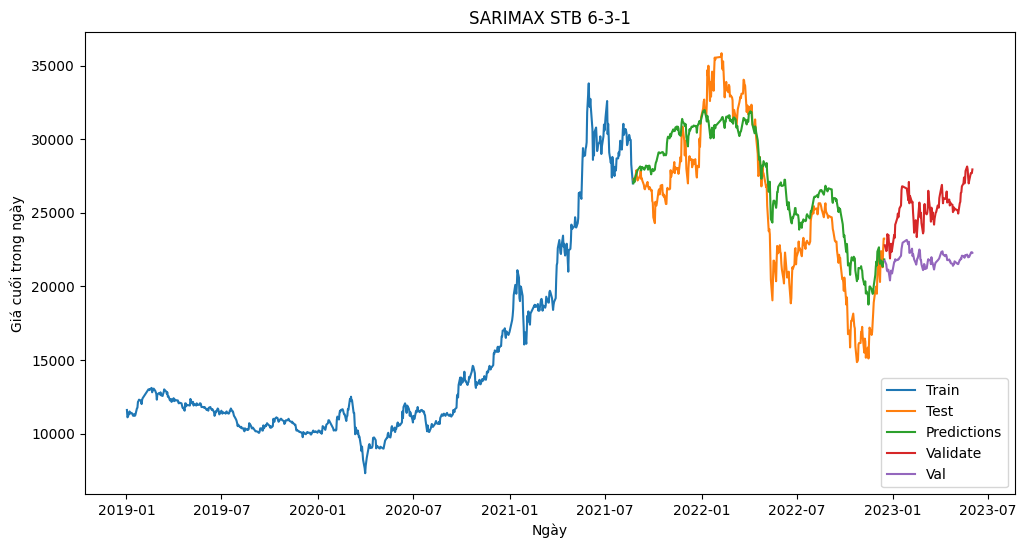

In [13]:
plt.figure(figsize=(12,6))
plt.plot(train)
plt.plot(test)
plt.plot(test.index,y_pred)
plt.plot(val)
plt.plot(val.index, y_pred_val)
#plt.plot(y_next_30_days)
plt.title('SARIMAX Forecast')
plt.xlabel('Ngày')
plt.ylabel('Giá cuối trong ngày')
plt.title(title)
#plt.legend(['Train', 'Test', 'Predictions','Validate','Val','Next 30 days'], loc='lower right')
plt.legend(['Train', 'Test', 'Predictions','Validate','Val'], loc='lower right')

In [14]:
#Các chỉ số Đánh giá 
def deviation(test, pred):
  rmse=np.sqrt(mean_squared_error(test,pred))
  print(f"RMSE: {rmse:.2f}")
  mape=mean_absolute_percentage_error(test,pred)
  print(f"MAPE: {mape*100:.2f}%")
  mae = mean_absolute_error(test, pred)
  print(f"MAE: {mae:.2f}")

In [15]:
deviation(y_test,y_pred)
deviation(y_val,y_pred_val)

RMSE: 2815.49
MAPE: 10.51%
MAE: 2391.18
RMSE: 3683.52
MAPE: 13.70%
MAE: 3519.84
